- _purpose_:Generate multiple DTMs from .laz files following the semi-established (but brittle) pipeline

- _status_: WIP

- _next_: Unsure

- _conclusion_: TBD

## PLAD Workshop -> Manipulation -> Identifying ground
link to PDAL workshop documentation: https://pdal.io/en/stable/workshop/manipulation/ground/ground.html

In [33]:
import os
import pandas as pd
import numpy as np
import sys
import time
import math

import io
import base64

import json
import pdal

import rasterio
import matplotlib.pyplot as plt

# compute absolute path to the project root's src/
sys.path.insert(0, os.path.join(os.getcwd(), "src"))

from project_utils import satellite as satellite
from project_utils import lidar as lidar
from project_utils import config as proj_config
from project_utils import io as proj_io

# auto-reload any module that changes on disk
%load_ext autoreload
%autoreload
# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# proj_io.authenticate_earthaccess()

[io] Authenticating with earthaccess...
[io] Authenticated: True


True

In [40]:
def pt(msg=None):
    current_time = time.strftime("%H:%M:%S")
    if msg:
        print(f"{current_time}: {msg}")
    else:
        print(current_time)

In [ ]:
CWD = os.getcwd()
FILENAME = "SAN_A02_2014_laz_0"
PIPELINE_TEMPLATE_DENOISE_NAME = "tutorial_denoise_ground"
PIPELINE_TEMPLATE_DTM_NAME = "tutorial_generate_dtm"

laz_dir = os.path.join(CWD, "data", "raw", "tiles", "laz")
laz_path = os.path.join(CWD, "data", "raw", "tiles", "laz", FILENAME + ".laz")
dtm_path = os.path.join(CWD, "data", "processed", "dtm", FILENAME + "_" + PIPELINE_TEMPLATE_DENOISE_NAME + ".tif")
denoised_laz_path = os.path.join(CWD, "data", "processed", "denoised", FILENAME + "_" + PIPELINE_TEMPLATE_DENOISE_NAME + ".copc.laz")

pipeline_dns_path = os.path.join(CWD, "config", "pdal_pipelines", PIPELINE_TEMPLATE_DENOISE_NAME + ".json")
pipeline_dtm_path = os.path.join(CWD, "config", "pdal_pipelines", PIPELINE_TEMPLATE_DTM_NAME + ".json")

os.makedirs(os.path.join(CWD, "data", "processed", "denoised"), exist_ok=True)

print(laz_path)   
print(dtm_path)
print(denoised_laz_path)
print(pipeline_dns_path)
print(denoised_laz_path)

for path in [laz_path, dtm_path, denoised_laz_path, pipeline_dns_path, pipeline_dtm_path]:
    print(os.path.exists(path))

path_to_tile_metadata = os.path.join(CWD, "data", "metadata", "cms_brazil_lidar_tile_metadata.csv")
print(os.path.exists(path_to_tile_metadata))

/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/tiles/laz/SAN_A02_2014_laz_0.laz
/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/dtm/SAN_A02_2014_laz_0_tutorial_denoise_ground.tif
/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/denoised/SAN_A02_2014_laz_0_tutorial_denoise_ground.copc.laz
/Users/jamesbyers/code/github/Kaggle/openai_to_z/config/pdal_pipelines/tutorial_generate_dtm.json
/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/denoised/SAN_A02_2014_laz_0_tutorial_denoise_ground.copc.laz
True
True
True
True
True


In [ ]:
path_to_tile_metadata = os.path.join(CWD, "data", "metadata", "cms_brazil_lidar_tile_metadata.csv")
print(os.path.exists(path_to_tile_metadata))

df = pd.read_csv(path_to_tile_metadata)

# 1. Order by "class_2_count" (descending, for example; use ascending=True if you want smallest first)
df_sorted = df.sort_values(by="class_2_pct", ascending=False)

# 2. Remove rows where "tile_area_m2" < 0.5e6
df_filtered = df_sorted[df_sorted["tile_area_m2"] >= 0.5e6]

# Optional: to reset the index
df_filtered = df_filtered.reset_index(drop=True)

index = 0
filename = df_filtered.iloc[index]['filename']
print(filename)
print(f"Classification 2 points: {df_filtered.iloc[index]['class_2_pct']*100:.2f} %")
print(f"Area: {df_filtered.iloc[index]['tile_area_m2']*1e-6} km **2")

coords = satellite.get_coords_from_df(df_filtered, filename)

# img = satellite.fetch_esri_from_coords(coords)
# 
# plt.figure(figsize=(6, 6))
# plt.imshow(img)
# plt.title(filename)
# plt.show()

proj_io.fetch_laz_file(filename, laz_dir, verbose=True, overwrite=True)

True
PRG_A01_2013_P06a_laz_4.laz
Classification 2 points: 42.22 %
Area: 0.6068099919705987 km **2
[io] Downloading PRG_A01_2013_P06a_laz_4.laz...
[io] Downloaded PRG_A01_2013_P06a_laz_4.laz to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/tiles/laz/PRG_A01_2013_P06a_laz_4.laz


PosixPath('/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/tiles/laz/PRG_A01_2013_P06a_laz_4.laz')

In [42]:
def minimal_laz_to_denoised(in_laz_path, out_laz_path, pipeline_template_path, verbose=0):
    pt("Checking input files")
    # Check input files
    if not os.path.isfile(in_laz_path):
        raise FileNotFoundError(f"Input .laz file not found: {in_laz_path}")
    if not os.path.isfile(pipeline_template_path):
        raise FileNotFoundError(f"Pipeline template not found: {pipeline_template_path}")
    
    pt("Reading PDAL pipelinetemplate")
    # Read and substitute template
    with open(pipeline_template_path, 'r', encoding='utf-8') as f:
        tpl = f.read()
    pt(f"Template:\n {tpl}")
    
    pt("Filling in pipeline template with in_laz and out_laz")
    pipeline_filled = tpl.format(in_laz=in_laz_path, out_laz=out_laz_path)
    pt(f"Filled in pipeline definition:\n{pipeline_filled}")
    try:
        pipeline_obj = json.loads(pipeline_filled)
        pt("Pipeline is valid JSON after subsitution")
    except Exception as e:
        raise ValueError(f"Pipeline is not valid JSON after substitution: {e}")
    

    # Accept dict with "pipeline" or direct list
    if isinstance(pipeline_obj, dict) and "pipeline" in pipeline_obj:
        pdal_pipe = pipeline_obj["pipeline"]
    elif isinstance(pipeline_obj, list):
        pdal_pipe = pipeline_obj
    else:
        raise ValueError("Pipeline template must be a list or a dict with a 'pipeline' key.")
    
    pt("Running PDAL pipeline")
    # Run PDAL pipeline
    pipe = pdal.Pipeline(json.dumps(pdal_pipe))
    count = pipe.execute()
    if verbose:
        print(f"Processed {count} points to {out_laz_path}")

    # Check output
    if not os.path.isfile(out_laz_path):
        raise RuntimeError(f"Output file not created: {out_laz_path}")
    return out_laz_path

In [56]:
pipeline_dns_path = "/Users/jamesbyers/code/github/Kaggle/openai_to_z/config/pdal_pipelines/tutorial_denoise_ground.json"
for index in range(5):
    filename = df_filtered.iloc[index]['filename']
    print(filename)
    print(f"Classification 2 points: {df_filtered.iloc[index]['class_2_pct']*100:.2f} %")
    print(f"Area: {df_filtered.iloc[index]['tile_area_m2']*1e-6} km **2")

    filename = os.path.splitext(filename)[0]
    laz_dir = os.path.join(CWD, "data", "raw", "tiles", "laz")
    laz_path = os.path.join(CWD, "data", "raw", "tiles", "laz", filename + ".laz")
    
    proj_io.fetch_laz_file(filename + ".laz", laz_dir, verbose=True, overwrite=False)

    # coords = satellite.get_coords_from_df(df_filtered, filename)

    denoised_laz_path = minimal_laz_to_denoised(laz_path, laz_path, pipeline_dns_path)

PRG_A01_2013_P06a_laz_4.laz
Classification 2 points: 42.22 %
Area: 0.6068099919705987 km **2
[io] PRG_A01_2013_P06a_laz_4.laz already exists in /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/tiles/laz, skipping download.
22:04:38: Checking input files
22:04:38: Reading PDAL pipelinetemplate
22:04:38: Template:
 {{
    "pipeline": [
      {{
        "type": "readers.las",
        "filename": "{in_laz}"
      }},
      {{
        "type": "filters.outlier",
        "method": "statistical",
        "mean_k": 8,
        "multiplier": 3.0
      }},
      {{
        "type": "filters.smrf",
        "ignore": "Classification[7:7]"
      }},
      {{
        "type": "filters.expression",
        "expression": "Classification == 2"
      }},
      {{
        "type": "writers.copc",
        "filename": "{out_laz}"
      }}
    ]
  }}
22:04:38: Filling in pipeline template with in_laz and out_laz
22:04:38: Filled in pipeline definition:
{
    "pipeline": [
      {
        "type": "reader

## PLAD Workshop -> Generation -> Generating a DTM
link to PDAL workshop documentation: https://pdal.io/en/stable/workshop/generation/dtm/dtm.html

At the start of this section of the notebook we should have a "denoised ground only" .laz file, which in this case is

In [14]:
print(f"Denoised laz path: {denoised_laz_path}")
os.path.exists(denoised_laz_path)

Denoised laz path: /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/denoised/SAN_A02_2014_laz_0_tutorial_denoise_ground.copc.laz


True

In [58]:
def denoised_to_dtm(in_laz_path, out_dtm_path, pipeline_template_path, verbose=0):
    pt("Checking input files")
    # Check input files
    if not os.path.isfile(in_laz_path):
        raise FileNotFoundError(f"Input .laz file not found: {in_laz_path}")
    if not os.path.isfile(pipeline_template_path):
        raise FileNotFoundError(f"Pipeline template not found: {pipeline_template_path}")
    
    pt("Reading PDAL pipelinetemplate")
    # Read and substitute template
    with open(pipeline_template_path, 'r', encoding='utf-8') as f:
        tpl = f.read()
    pt(f"Template:\n {tpl}")
    
    pt("Filling in pipeline template with in_laz and out_laz")
    pipeline_filled = tpl.format(in_laz=in_laz_path, out_tif=out_dtm_path)
    pt(f"Filled in pipeline definition:\n{pipeline_filled}")
    try:
        pipeline_obj = json.loads(pipeline_filled)
        pt("Pipeline is valid JSON after subsitution")
    except Exception as e:
        raise ValueError(f"Pipeline is not valid JSON after substitution: {e}")
    

    # Accept dict with "pipeline" or direct list
    if isinstance(pipeline_obj, dict) and "pipeline" in pipeline_obj:
        pdal_pipe = pipeline_obj["pipeline"]
    elif isinstance(pipeline_obj, list):
        pdal_pipe = pipeline_obj
    else:
        raise ValueError("Pipeline template must be a list or a dict with a 'pipeline' key.")
    
    pt("Running PDAL pipeline")
    # Run PDAL pipeline
    pipe = pdal.Pipeline(json.dumps(pdal_pipe))
    count = pipe.execute()
    if verbose:
        print(f"Processed {count} points to {out_dtm_path}")

    # Check output
    if not os.path.isfile(out_dtm_path):
        raise RuntimeError(f"Output file not created: {out_dtm_path}")
    return out_dtm_path

In [ ]:
dtm_path = os.path.join(CWD, "data", "processed", "dtm", FILENAME + "_" + PIPELINE_TEMPLATE_DENOISE_NAME + ".tif")
denoised_laz_path = os.path.join(CWD, "data", "processed", "denoised", FILENAME + "_" + PIPELINE_TEMPLATE_DENOISE_NAME + ".copc.laz")

In [64]:
for index in range(5):
    filename = df_filtered.iloc[index]['filename']
    print(filename)

    FILENAME = os.path.splitext(filename)[0]

    laz_path = os.path.join(CWD, "data", "raw", "tiles", "laz", filename)
    dtm_path = os.path.join(CWD, "data", "processed", "dtm", filename + "_" + "denoised" + "_" + PIPELINE_TEMPLATE_DENOISE_NAME + ".tif")
    # print(f"Classification 2 points: {df_filtered.iloc[index]['class_2_pct']*100:.2f} %")
    # print(f"Area: {df_filtered.iloc[index]['tile_area_m2']*1e-6} km **2")

    # filename = os.path.splitext(filename)[0]
    
    out_dtm_path = denoised_to_dtm(laz_path, dtm_path, pipeline_dtm_path)

PRG_A01_2013_P06a_laz_4.laz
22:59:49: Checking input files
22:59:49: Reading PDAL pipelinetemplate
22:59:49: Template:
 {{
    "pipeline": [
        {{
            "type": "readers.las",
            "filename": "{in_laz}"
        }},
        {{
            "filename":"{out_tif}",
            "gdaldriver":"GTiff",
            "output_type":"min",
            "resolution":"2.0",
            "type": "writers.gdal"
        }}
    ]
}}
22:59:49: Filling in pipeline template with in_laz and out_laz
22:59:49: Filled in pipeline definition:
{
    "pipeline": [
        {
            "type": "readers.las",
            "filename": "/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/raw/tiles/laz/PRG_A01_2013_P06a_laz_4.laz"
        },
        {
            "filename":"/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/dtm/PRG_A01_2013_P06a_laz_4.laz_denoised_tutorial_denoise_ground.tif",
            "gdaldriver":"GTiff",
            "output_type":"min",
            "resolution":"2

In [113]:
# Taken from https://www.neonscience.org/resources/learning-hub/tutorials/create-hillshade-py
# Hillshade calculation
def hillshade(array, azimuth, angle_altitude):
    azimuth = 360.0 - azimuth
    x, y = np.gradient(array)
    slope = np.pi / 2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azm_rad = azimuth * np.pi / 180.
    alt_rad = angle_altitude * np.pi / 180.
    shaded = np.sin(alt_rad) * np.sin(slope) + np.cos(alt_rad) * np.cos(slope) * np.cos((azm_rad - np.pi/2.) - aspect)
    return 255 * (shaded + 1) / 2

def encode_image(array, cmap='terrain', vmin=None, vmax=None):
    clean_arr = np.nan_to_num(array, nan=-1)
    plt.figure(figsize=(10, 6))
    plt.imshow(clean_arr, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.tight_layout()
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg', bbox_inches='tight', dpi=150)
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode('utf-8')

def process_dtm_tile(out_dtm_path):
    with rasterio.open(out_dtm_path) as src:
        dem = src.read(1)
        dem = np.where(dem == src.nodata, np.nan, dem)

        # Normalize DEM for color image
        vmin = np.nanpercentile(dem, 2)
        vmax = np.nanpercentile(dem, 98)

        dem_base64 = encode_image(dem, cmap='terrain', vmin=vmin, vmax=vmax)

        # Generate hillshade from filled DEM
        dem_filled = np.nan_to_num(dem, nan=np.nanmean(dem))
        hs = hillshade(dem_filled, azimuth=315, angle_altitude=45)
        hillshade_base64 = encode_image(hs, cmap='gray')

        return dem_base64, hillshade_base64

In [192]:
files = os.listdir(os.path.join(CWD, "data", "processed", "dtm"))
print(files)
index = -1

['PRG_A01_2013_P06a_laz_4.laz_denoised_tutorial_denoise_ground.tif', 'PRG_A01_2013_P06a_laz_4_tutorial_denoise_ground.tif', 'SAN_A02_2014_laz_0_tutorial_denoise_ground.tif', 'PRG_A01_2013_P08a_laz_9.laz_denoised_tutorial_denoise_ground.tif', 'SFX_A01_2012_laz_0.laz_denoised_tutorial_denoise_ground.tif', 'PRG_A01_2013_P07a_laz_1.laz_denoised_tutorial_denoise_ground.tif', 'SFX_A01_2012_laz_1.laz_denoised_tutorial_denoise_ground.tif']


0
/Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/dtm/PRG_A01_2013_P06a_laz_4.laz_denoised_tutorial_denoise_ground.tif
Number of bands (layers): 1
Shape (height, width): 302 500
CRS: None
Data type: float64
Bounds: BoundingBox(left=281000.0, bottom=9648396.15, right=282000.0, top=9649000.15)
Other metadata: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 500, 'height': 302, 'count': 1, 'crs': None, 'transform': Affine(2.0, 0.0, 281000.0,
       0.0, -2.0, 9649000.15)}
136.95347602649005



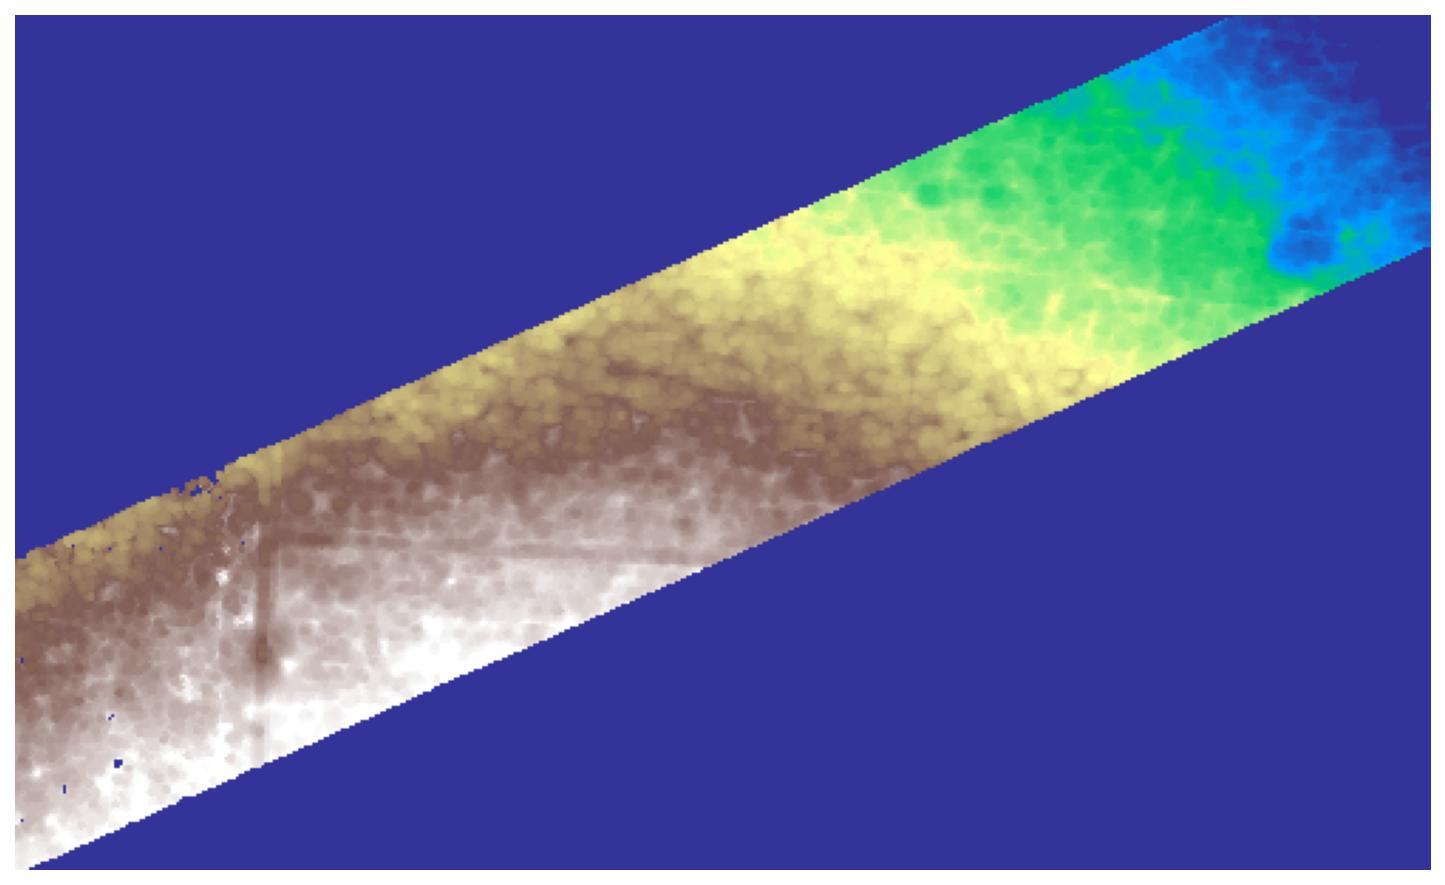
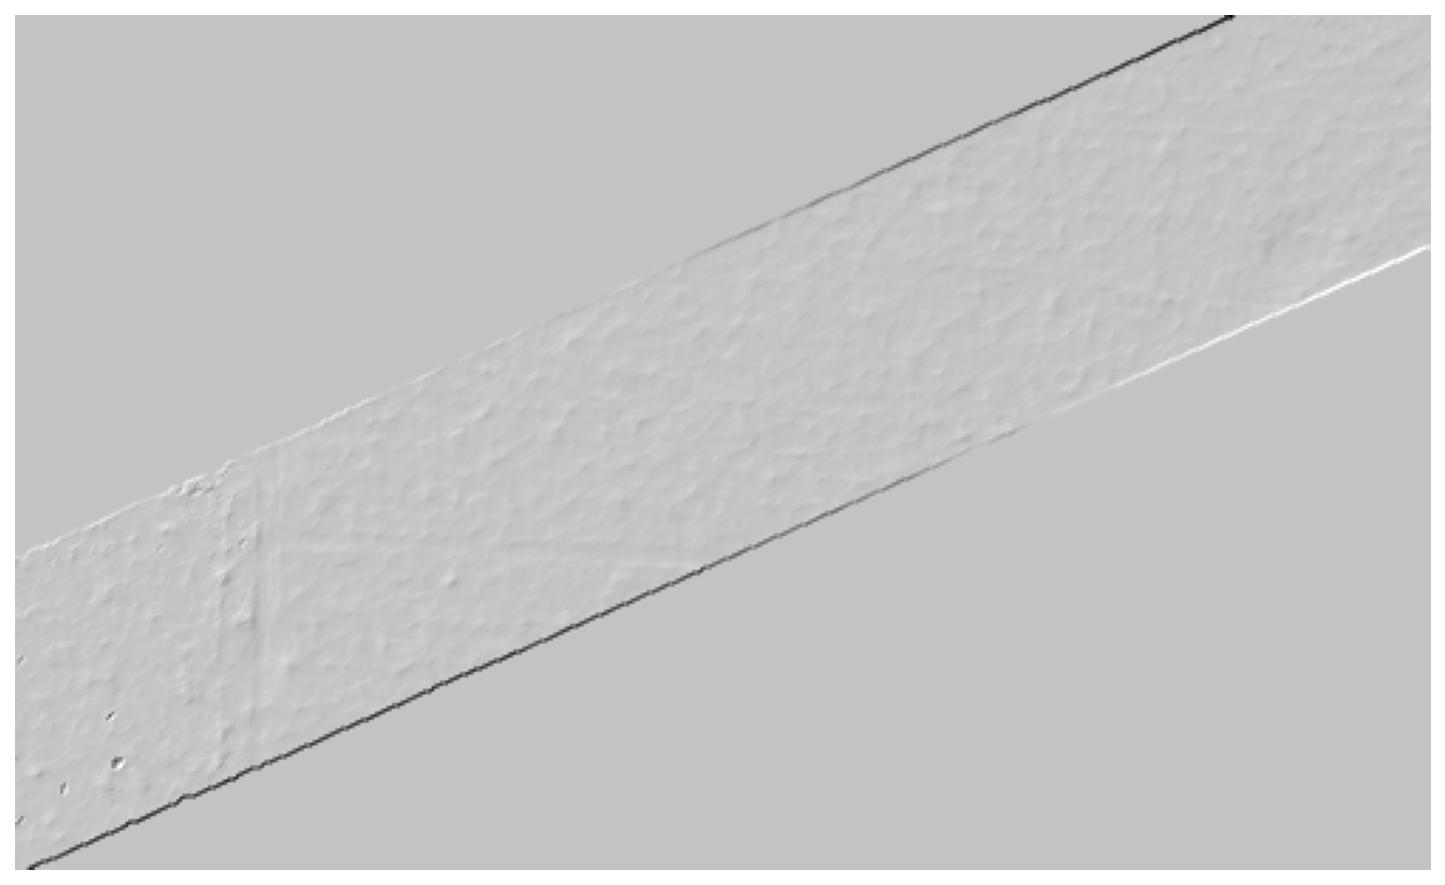

In [193]:
index += 1
print(index)
out_dtm_path = os.path.join(CWD, "data", "processed", "dtm", files[index])
print(out_dtm_path)

with rasterio.open(out_dtm_path) as src:
    print("Number of bands (layers):", src.count)
    print("Shape (height, width):", src.height, src.width)
    print("CRS:", src.crs)
    print("Data type:", src.dtypes[0])
    print("Bounds:", src.bounds)
    print("Other metadata:", src.meta)

nodata_value = -9999  # or np.nan, but use a finite value for GeoTIFFs!

with rasterio.open(out_dtm_path) as src:
    meta = src.meta.copy()
    meta.update(nodata=nodata_value)
    bands = []
    for i in range(1, src.count + 1):
        arr = src.read(i)
        arr_clean = np.where(arr < 0, 100, arr)
        print(np.mean(arr_clean))
        bands.append(arr_clean)
    data = np.stack(bands)
    
dem_b64, hillshade_b64 = process_dtm_tile(out_dtm_path)

from IPython.display import HTML
HTML(f"""
<h3>DTM (Terrain Color)</h3>
<img src="data:image/jpeg;base64,{dem_b64}" width="600"/>
<h3>Hillshade</h3>
<img src="data:image/jpeg;base64,{hillshade_b64}" width="600"/>
""")


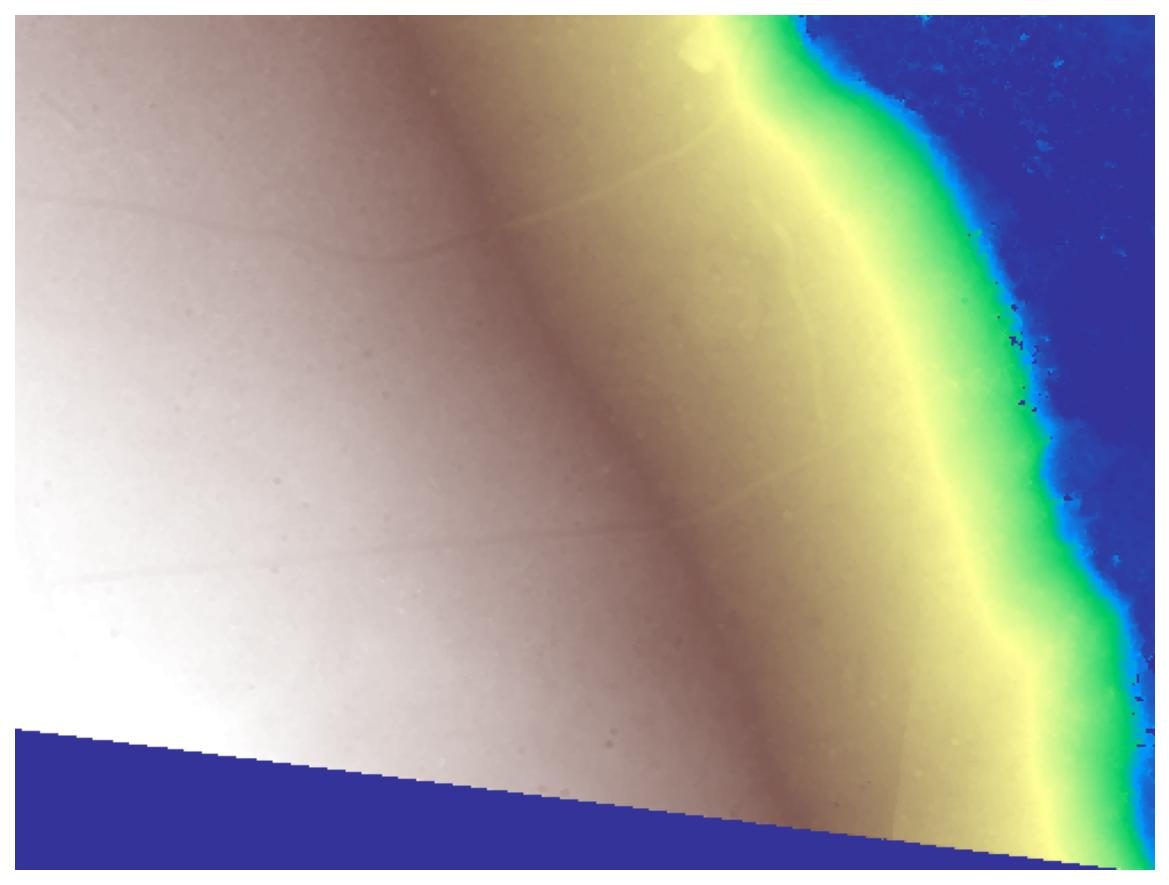
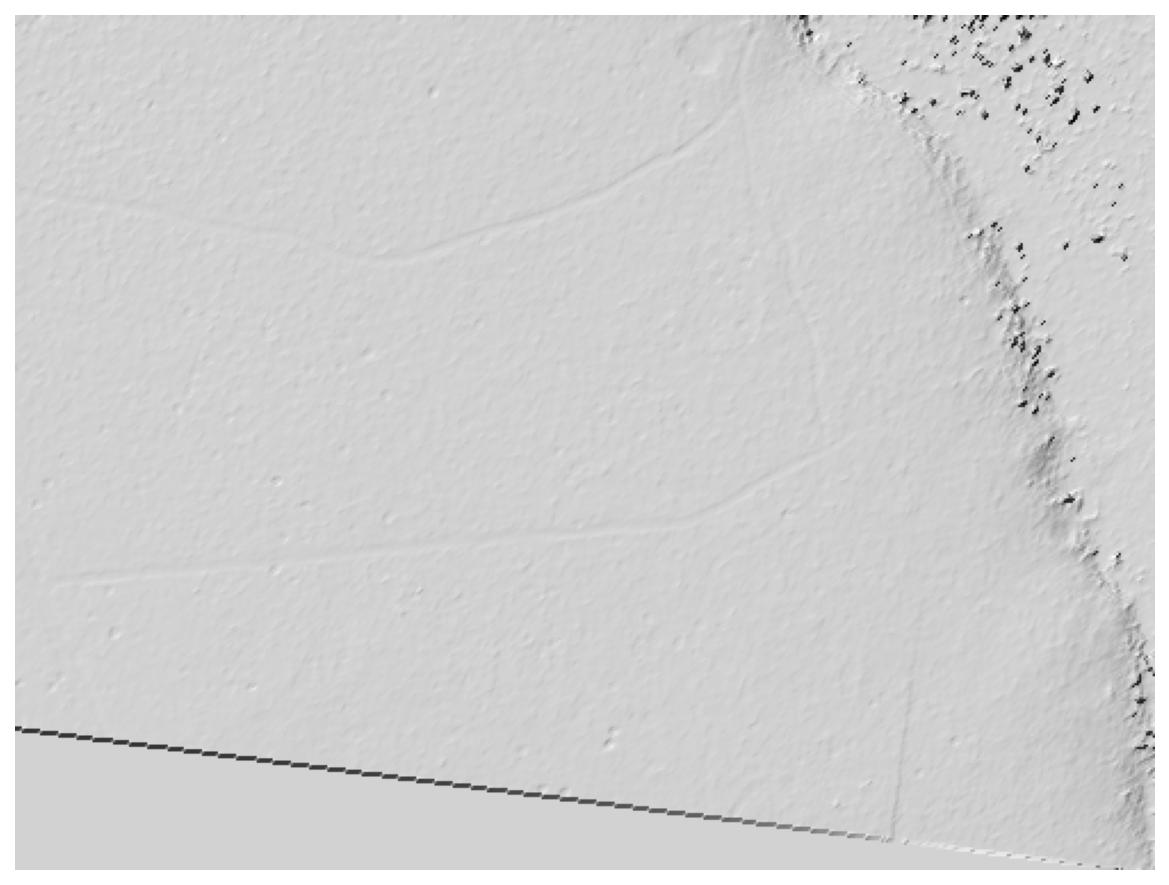

In [190]:
def process_dtm_tile(out_dtm_path):
    with rasterio.open(out_dtm_path) as src:
        dem = src.read(1)
        dem = np.where(dem == src.nodata, np.nan, dem)

        # Normalize DEM for color image
        vmin = np.nanpercentile(dem, 2)
        vmax = np.nanpercentile(dem, 98)

        dem_base64 = encode_image(dem, cmap='terrain', vmin=vmin, vmax=vmax)

        # Generate hillshade from filled DEM
        dem_filled = np.nan_to_num(dem, nan=np.nanmean(dem))
        hs = hillshade(dem_filled, azimuth=315, angle_altitude=45)
        hillshade_base64 = encode_image(hs, cmap='gray')

        return dem_base64, hillshade_base64
    
dem_b64, hillshade_b64 = process_dtm_tile(out_dtm_path)

from IPython.display import HTML
HTML(f"""
<h3>DTM (Terrain Color)</h3>
<img src="data:image/jpeg;base64,{dem_b64}"/>
<h3>Hillshade</h3>
<img src="data:image/jpeg;base64,{hillshade_b64}"/>
""")

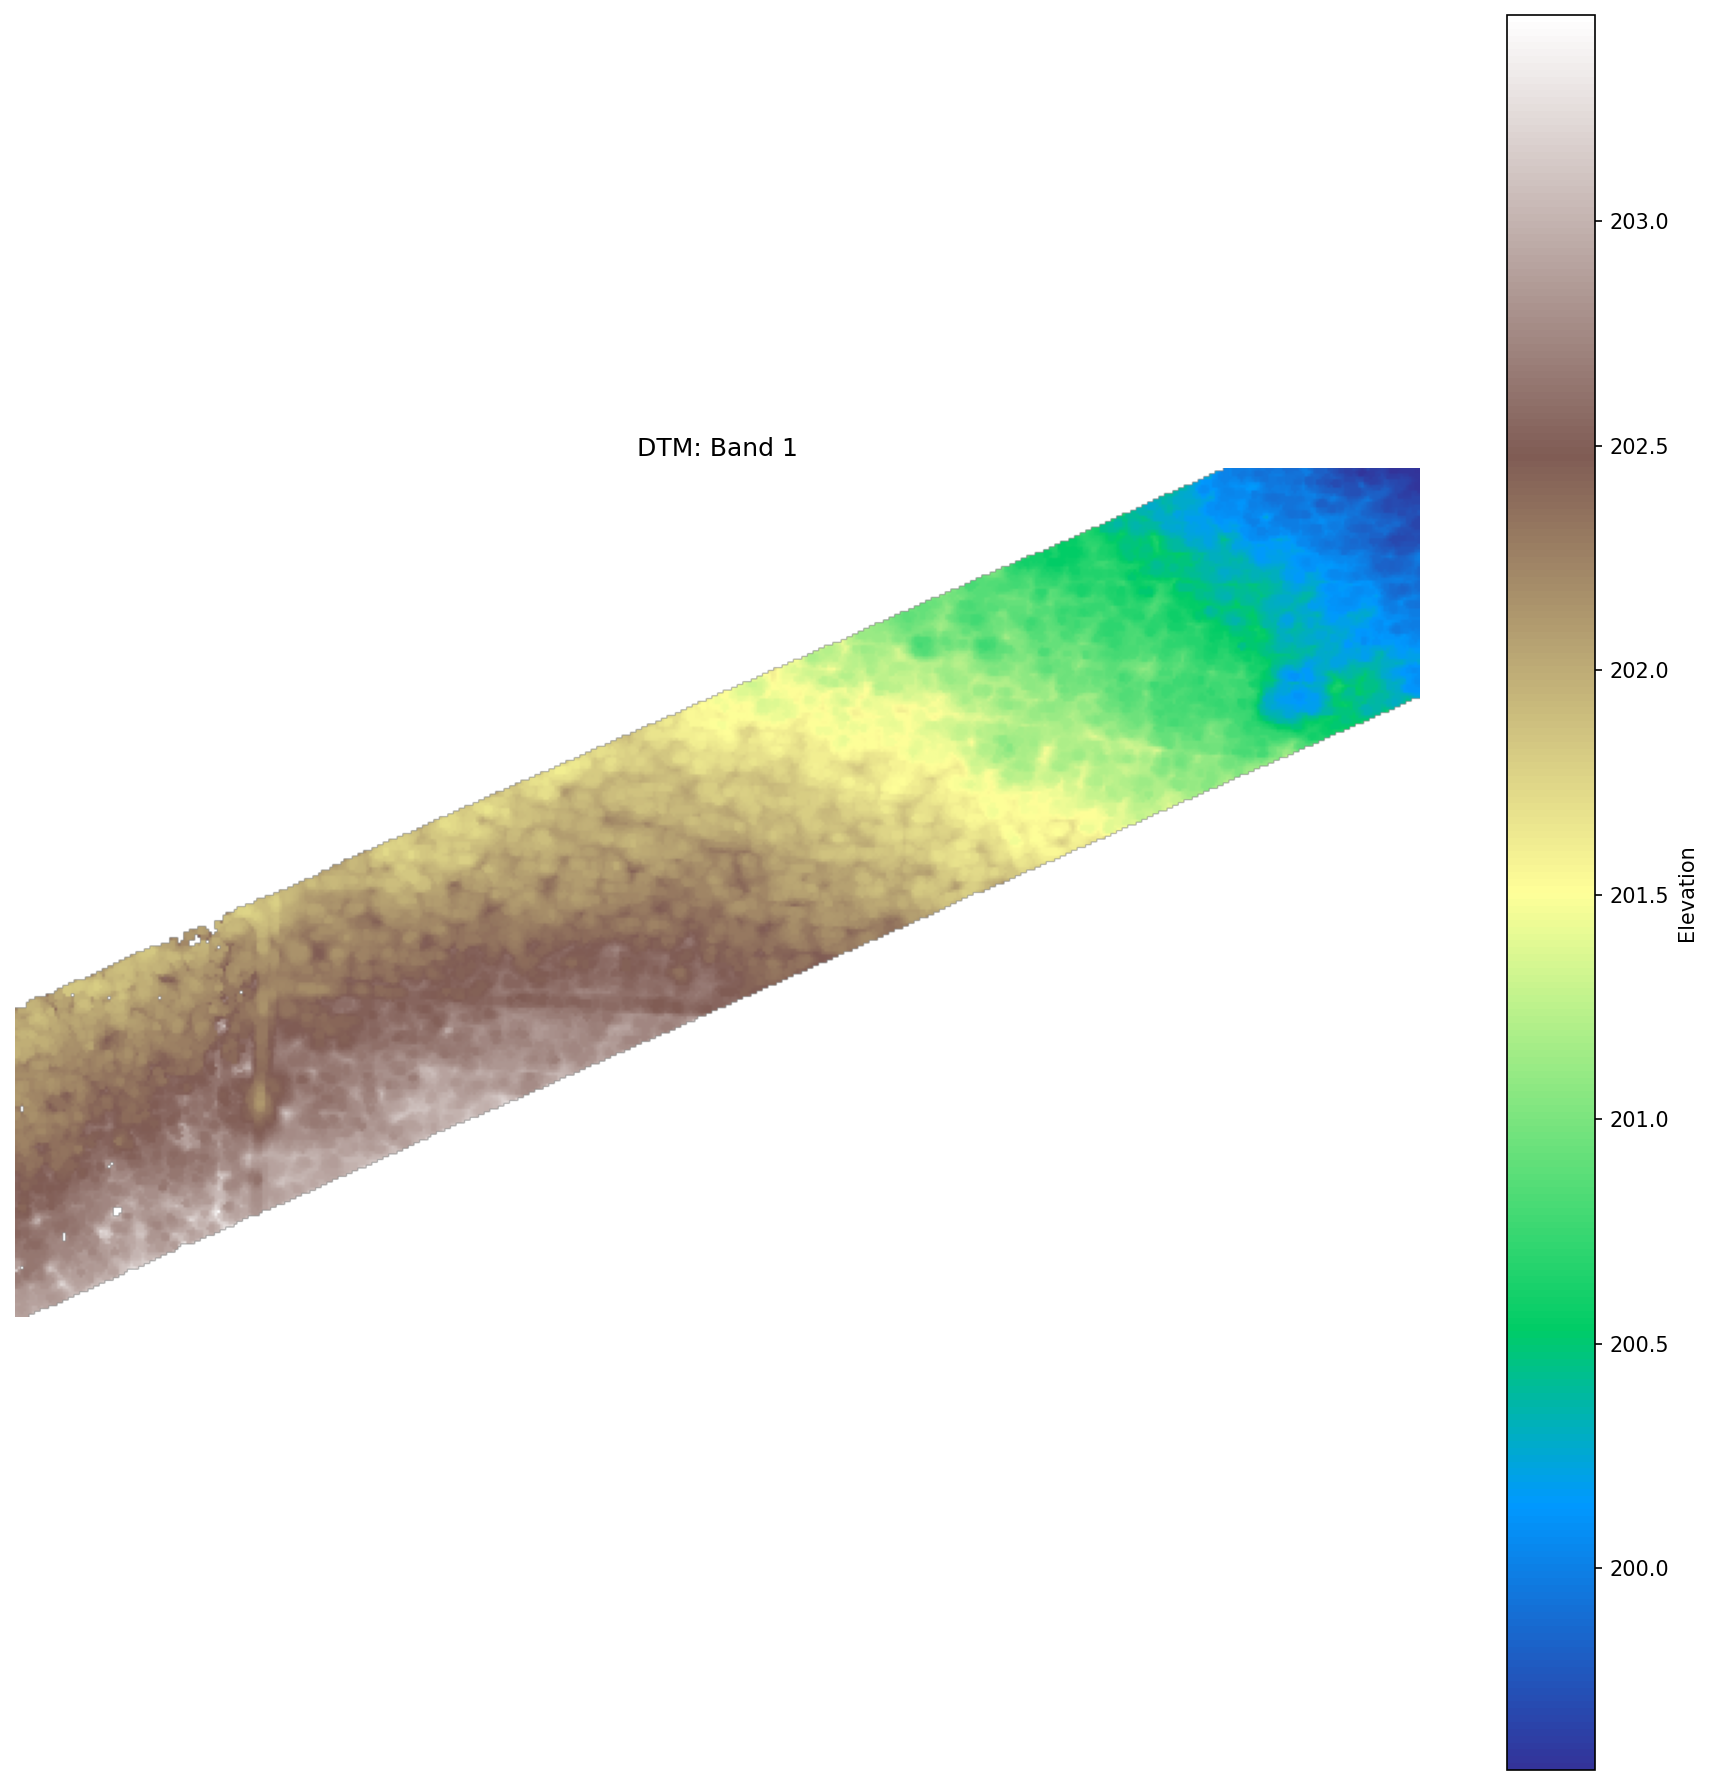

In [84]:
out_image = "my_dtm_highres.png"

with rasterio.open(out_dtm_path) as src:
    band = src.read(1)
    # Mask nodata for visualization
    nodata = src.nodata
    if nodata is not None:
        band = np.where(band == nodata, np.nan, band)
    plt.figure(figsize=(12, 12), dpi=150)  # Make bigger for more apparent detail
    plt.imshow(band, cmap="terrain")
    plt.colorbar(label='Elevation')
    plt.title("DTM: Band 1")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_image, bbox_inches='tight', pad_inches=0)
    plt.show()